<a href="https://colab.research.google.com/github/DimaSidorenko/Deep_learning/blob/master/ACDC_Challenge_using_U_NET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!pip install medpy

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 153kB 2.6MB/s 
     |████████████████████████████████| 42.5MB 71kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753443 sha256=60f4ac66bd60bf8bfe71535c961deb1c0454284970abb24cd0803b1d6d6c7e5c
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


In [0]:
#kek = load_nii('')
import os
from glob import glob
import time
import re
import argparse
import nibabel as nib
import pandas as pd
from medpy.metric.binary import hd, dc
import numpy as np

In [0]:
def load_nii(img_path):
    nimg = nib.load(img_path)
    return nimg.get_data(), nimg.affine, nimg.header


def save_nii(img_path, data, affine, header):
    nimg = nib.Nifti1Image(data, affine=affine, header=header)
    nimg.to_filename(img_path)


In [0]:
#Считываем изображения сердца из папки ('/content/drive/My Drive/original_files/'). При этом все изображения сердца должны быть загружены в эту папку.
img_dict = dict()
for filename in os.listdir('/content/drive/My Drive/original_files/'):
    file_t = filename[:-7]
    img_dict[file_t] = load_nii(os.path.join('/content/drive/My Drive/original_files/',filename))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
#Считываем изображения маски из папки ('/content/drive/My Drive/mask_files'). При этом все маски должны быть загружены в эту папку.
mask_dict = dict()
for filename in os.listdir('/content/drive/My Drive/mask_files'):
  file_t = filename[:-10]
  mask_dict[file_t] = load_nii(os.path.join('/content/drive/My Drive/mask_files',filename))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


ImageFileError: ignored

In [0]:
from scipy.ndimage import zoom

def get_train_data(img_dict,mask_dict):
  x_train,y_train = [],[]

  i = 0
  for key in img_dict.keys():
    img = img_dict[key][0]
    mask = mask_dict[key][0]

    x_t = []
    y_t = []
    for j in range(img.shape[2]):
      x_t.append(np.array(img[:,:,j]/255).astype('float64'))
      y_t.append(np.array(mask[:,:,j]).astype('float64'))
    
    for i in range(len(x_t)):
      x_train.append(zoom(x_t[i],(128/x_t[i].shape[0],128/x_t[i].shape[1]),order=0))
      y_train.append(zoom(y_t[i],(128/y_t[i].shape[0],128/y_t[i].shape[1]),order=0))

  return np.array(x_train),np.array(y_train)

In [0]:
x_train,y_train = get_train_data(img_dict,mask_dict)

In [0]:
#сохранение x_train, y_train чтобы каждый раз не считывать данные. Теперь просто можем загрузить x_train, y_train.
#Saving x_train, y_train on Google Drive. Now we don't need to load nii files, we can simply load x_train and y_train from Google Drive
np.save('/content/drive/My Drive/x_train', x_train)
np.save('/content/drive/My Drive/y_train', y_train)

In [0]:
#Load x_train, y_train from Google Drive.
x_train = np.load('/content/drive/My Drive/x_train.npy')
y_train = np.load('/content/drive/My Drive/y_train.npy')

In [0]:
eps = 0.000000000001
y_train1 = (abs(y_train-1.)<eps).astype('float64')
y_train2 = (abs(y_train-2.)<eps).astype('float64')
y_train3 = (abs(y_train-3.)<eps).astype('float64') 
y_train4 = (abs(y_train)<eps).astype('float64')

In [0]:
y_train = np.stack((y_train1,y_train2,y_train3,y_train4),axis=3)

In [0]:
y_train.shape

(1902, 128, 128, 4)

In [0]:
#permute x_train, y_train
perm =np.random.permutation(x_train.shape[0])
x_train = x_train[perm]
y_train = y_train[perm]

In [0]:
#Unet + dise_coef
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow as tf
from keras import backend as K


def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pref_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def unet(input_size = (128,128,1),coef = 1):
    
    inputs = Input(input_size)
    conv1 = Conv2D(64//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    
    #conv1 = Dropout(0.3)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512//coef, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256//coef, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128//coef, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64//coef, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64//coef, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(4, 1, activation = 'softmax')(conv9)
    
    model = Model(input = inputs, output = conv10)
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [iou_coef,dice_coef])

    return model

In [0]:
model = unet()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_26[0][0]                  
____________________________________________________________________________________________

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.3)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2)

In [0]:
from keras.callbacks.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

best_model = ModelCheckpoint('ACDC_UNET_V3.h5', monitor='dice_coef', verbose=1, save_best_only=True,save_weights_only=True,mode='max')

#Augmentation
#gen = ImageDataGenerator(rotation_range=15,zoom_range=0.1)
#aug_iter = gen.flow(x_train.reshape(-1,128,128,1),y_train,batch_size=32)

#early_stop1 = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [0]:
#Training with Augmentation
#history = model.fit_generator(aug_iter,epochs=50,verbose=1,validation_data=(x_val.reshape(-1,128,128,1),y_val),callbacks=[best_model])

NameError: ignored

In [0]:
#Training without Augmentation
model.fit(x_train.reshape(-1,128,128,1),
          y_train.reshape(-1,128,128,4),
           batch_size=32,
           epochs=50,
           verbose=1,
           validation_split=0.2,
           callbacks=[best_model])

Train on 851 samples, validate on 213 samples
Epoch 1/50
851/851 [==============================] - 57s 67ms/step - loss: 0.2585 - iou_coef: 0.6672 - dice_coef: 0.7631 - val_loss: 0.1740 - val_iou_coef: 0.6098 - val_dice_coef: 0.7504

Epoch 00001: dice_coef improved from -inf to 0.76306, saving model to ACDC_UNET_V3.h5
Epoch 2/50
851/851 [==============================] - 33s 39ms/step - loss: 0.0856 - iou_coef: 0.8572 - dice_coef: 0.9215 - val_loss: 0.0647 - val_iou_coef: 0.8290 - val_dice_coef: 0.9059

Epoch 00002: dice_coef improved from 0.76306 to 0.92147, saving model to ACDC_UNET_V3.h5
Epoch 3/50
851/851 [==============================] - 32s 38ms/step - loss: 0.0506 - iou_coef: 0.8923 - dice_coef: 0.9427 - val_loss: 0.0593 - val_iou_coef: 0.8390 - val_dice_coef: 0.9120

Epoch 00003: dice_coef improved from 0.92147 to 0.94273, saving model to ACDC_UNET_V3.h5
Epoch 4/50
851/851 [==============================] - 33s 39ms/step - loss: 0.0436 - iou_coef: 0.9014 - dice_coef: 0.9478 -

In [0]:
#from google.colab import files
#files.download('ACDC_UNET1_V2.h5')
#files.download('ACDC_UNET2_V2.h5')
#files.download('ACDC_UNET3_V3.h5')

In [0]:
from keras.models import load_model
# load models
model.load_weights('ACDC_UNET_V3.h5')


In [0]:
acc = model.evaluate(x_test.reshape(-1,128,128,1),y_test.reshape(-1,128,128,4))
print(model.metrics_names)
print(acc)

571/571 [==============================] - 10s 18ms/step
['loss', 'iou_coef', 'dice_coef']
[0.014846326592468026, 0.9774359464645386, 0.988530158996582]


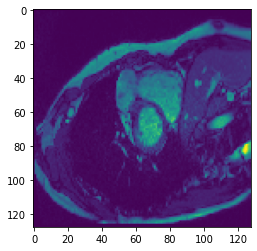

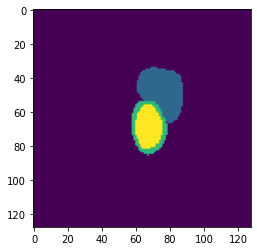

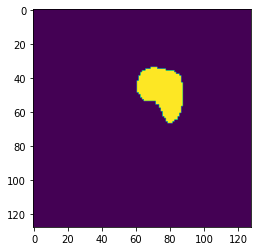

In [0]:
idx = 5
out1 = model1.predict(x_train[idx].reshape(-1,128,128,1))
out2 = model2.predict(x_train[idx].reshape(-1,128,128,1))
out3 = model3.predict(x_train[idx].reshape(-1,128,128,1))

plt.imshow(x_train[idx])
plt.show()
plt.imshow(y_train[idx])
plt.show()
plt.imshow(y_train1[idx])
plt.show()

In [0]:
import glob
import shutil

!rm -rf '/content/drive/My Drive/original_files'
!mkdir '/content/drive/My Drive/original_files'

#копирование тестовых данных в отдельный каталог original_files

for top, dirs, files in os.walk('/content/drive/My Drive/testing/testing'):
    for file in glob.glob(top + '/*[0-9].nii.gz'):
        shutil.copy(file, '/content/drive/My Drive/original_files')

In [0]:
import os
test_dict = dict()

for filename in os.listdir('/content/drive/My Drive/original_files'):
    file_t = filename[:-7]
    test_dict[file_t] = load_nii(os.path.join('/content/drive/My Drive/original_files',filename))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  del sys.path[0]


In [0]:
import numpy as np
from scipy.ndimage import zoom

def get_test_data(test_dict):
  x_test = []

  i = 0
  for key in img_dict.keys():
    img = img_dict[key][0]

    x_t = []
    for j in range(img.shape[2]):
      x_t.append(np.array(img[:,:,j]/255).astype('float64'))
    
    for i in range(len(x_t)):
      x_test.append(zoom(x_t[i],(128/x_t[i].shape[0],128/x_t[i].shape[1]),order=0))
  
  return np.array(x_test)

In [0]:
x_test = get_test_data(test_dict)

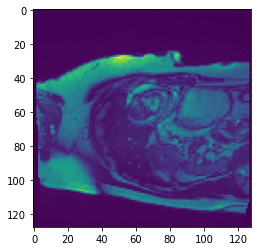

In [0]:
import matplotlib.pyplot as plt
plt.imshow(x_test[idx])
plt.show()

In [0]:
np.save('/content/drive/My Drive/x_test', x_test)

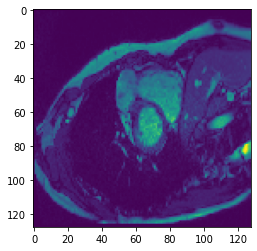

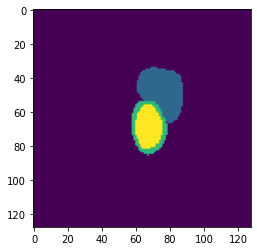

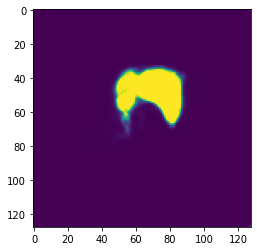

In [0]:
import matplotlib.pyplot as plt

out1,out2,out3

def concat_img(a1,a2,a3):
  a1 =a1.reshape(128,128)
  a2 = a2.reshape(128,128)
  a3 = a3.reshape(128,128)

  res = np.zeros((128,128))
  for i in range(128):
    for j in range(128):
      k = np.array([a1[i,j],a2[i,j],a3[i,j]])
      #pix1,pix2,pix3
      kek = k.argmax()

      if (k[kek]<0.5):
        res[i,j] = 0
      else:
        res[i,j] = kek+1
    
    
  return res

idx = 5
plt.imshow(x_train[idx])
plt.show()
plt.imshow(y_train[idx])
plt.show()

out1 = model1.predict(x_train[idx].reshape(-1,128,128,1))
out2 = model2.predict(x_train[idx].reshape(-1,128,128,1))
out3 = model3.predict(x_train[idx].reshape(-1,128,128,1))

plt.imshow(out1.reshape(128,128))
plt.show()
#plt.imshow(concat_img(out1,out2,out3))
#plt.show()


#plt.imshow(out1.reshape(128,128))
#plt.show()
#plt.imshow(out2.reshape(128,128))
#plt.show()

#plt.imshow(out3.reshape(128,128))
#plt.show()